<a href="https://colab.research.google.com/github/Steven256-debug/Credit-card-fraud-detection/blob/main/CREDIT_CARD_FRAUD_DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation of libraries


In [1]:
# ===============================
# Credit Card Fraud Detection System
# Starter Notebook for Team Collaboration
# Team: Steven Tesla, Aaron, Kenzie, Kelvin, Fada Dem
# ===============================

# -------------------------------
# 1️⃣ Install Required Libraries
# -------------------------------
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn xgboost lightgbm joblib kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import os


UPLOAD DATASET MANUALLY

In [2]:
# Upload dataset manually (Colab will prompt you)
from google.colab import files
uploaded = files.upload()  # Choose your Excel file (credit_card_fraud_dataset.xlsx)
# After upload, get the uploaded filename
import io, os
fn = list(uploaded.keys())[0]
print("Uploaded file:", fn)


Saving credit_card_fraud_dataset.csv to credit_card_fraud_dataset.csv
Uploaded file: credit_card_fraud_dataset.csv


Load dataset & preview

In [4]:
# Load Excel file and inspect columns / sample rows
import pandas as pd, numpy as np
df = pd.read_csv(fn)
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())

Shape: (100000, 7)

Columns:
['TransactionID', 'TransactionDate', 'Amount', 'MerchantID', 'TransactionType', 'Location', 'IsFraud']

First 5 rows:


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


Detect target column and basic stats

In [13]:
# Attempt to auto-detect target column from common names
TARGET_CANDIDATES = ["Class","class","isFraud","IsFraud","fraud","Fraud","label","Label","is_fraud","target"]
target = None
for t in TARGET_CANDIDATES:
    if t in df.columns:
        target = t
        break

print("Auto-detected target column:", target)
if target is None:
    print("No common target found. Please inspect df.columns and set TARGET manually in the next cell.")
else:
    print("Using target =", target)

# Basic class counts if detected
if target:
    print("\nClass distribution:")
    print(df[target].value_counts(dropna=False))


Auto-detected target column: IsFraud
Using target = IsFraud

Class distribution:
IsFraud
0    99000
1     1000
Name: count, dtype: int64


EDA: distributions, missingness, correlations

Top missing rates:


,0
TransactionID,0.0
TransactionDate,0.0
Amount,0.0
MerchantID,0.0
IsFraud,0.0
hour,0.0
day_of_week,0.0
month,0.0
norm_amount,0.0
TransactionType_refund,0.0


Numeric columns count: 8


,count,mean,std,min,25%,50%,75%,max
TransactionID,100000.0,5.000050e+04,28867.657797,1.000000,25000.750000,50000.500000,75000.250000,100000.000000
Amount,100000.0,2.497093e+03,1442.415999,1.050000,1247.955000,2496.500000,3743.592500,4999.770000
MerchantID,100000.0,5.016761e+02,288.715868,1.000000,252.000000,503.000000,753.000000,1000.000000
IsFraud,100000.0,1.000000e-02,0.099499,0.000000,0.000000,0.000000,0.000000,1.000000
hour,100000.0,1.150084e+01,6.917680,0.000000,6.000000,12.000000,17.000000,23.000000
day_of_week,100000.0,3.017040e+00,1.999027,0.000000,1.000000,3.000000,5.000000,6.000000
month,100000.0,6.516240e+00,3.448248,1.000000,4.000000,7.000000,10.000000,12.000000
norm_amount,100000.0,-1.006484e-16,1.000005,-1.730468,-0.866008,-0.000411,0.864179,1.735068


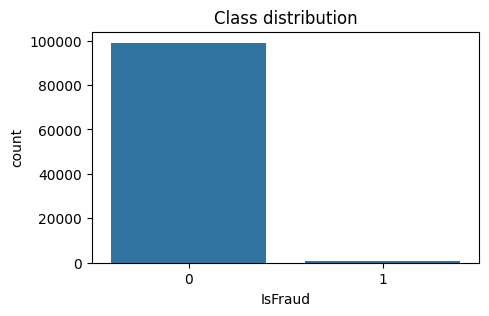

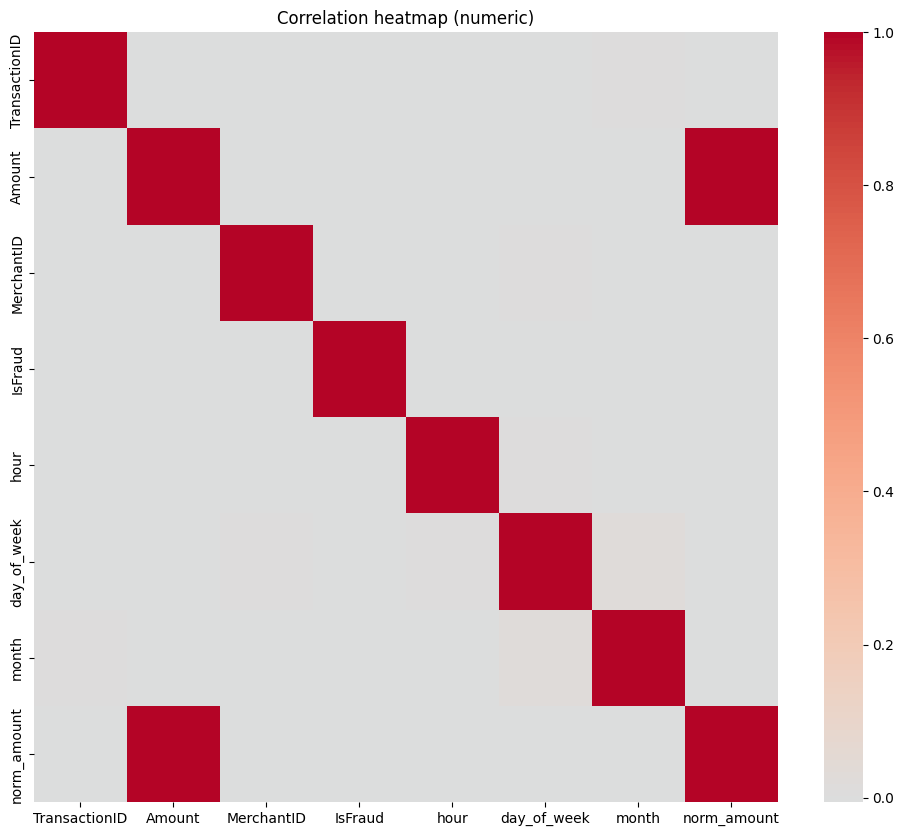

In [15]:
# EDA: missing values, numeric distributions, correlation heatmap for numeric features
import matplotlib.pyplot as plt, seaborn as sns
pd.set_option('display.max_columns', None)

# Missing rate
missing = df.isnull().mean().sort_values(ascending=False)
print("Top missing rates:")
display(missing.head(20))

# Numeric overview
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns count:", len(num_cols))
display(df[num_cols].describe().T)

# Visualize class imbalance if target exists
if target in df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[target])
    plt.title("Class distribution")
    plt.show()

# Correlation heatmap for numeric columns (sample if too many)
corr_cols = num_cols if len(num_cols) <= 40 else num_cols[:40]
plt.figure(figsize=(12,10))
sns.heatmap(df[corr_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation heatmap (numeric)")
plt.show()

Target column identified: 'IsFraud'

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB
None

DataFrame Description:
       TransactionID         Amount     MerchantID        IsFraud
count  100000.000000  100000.000000  100000.000000  100000.000000
mean    50000.500000    2497.092666     501.676070       0.010000
std     28867.657797    1442.415999     288.715868       0.099499
min         1.000000       1.050000       1.000000       0.0

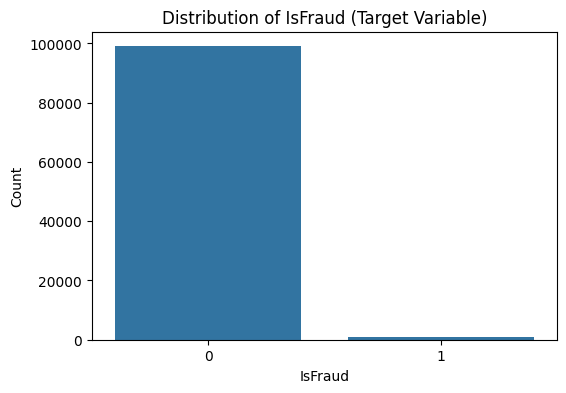

In [5]:
# Identify target column and display basic statistics
print("Target column identified: 'IsFraud'")

print("\nDataFrame Info:")
print(df.info())

print("\nDataFrame Description:")
print(df.describe())

# Check the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='IsFraud', data=df)
plt.title('Distribution of IsFraud (Target Variable)')
plt.xlabel('IsFraud')
plt.ylabel('Count')
plt.show()

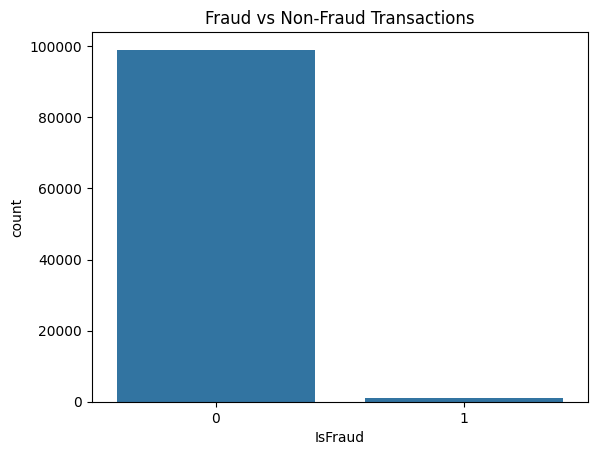

In [6]:
# -------------------------------
# 4️⃣ Exploratory Data Analysis (EDA)
# -------------------------------

# Check class distribution
sns.countplot(x='IsFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

Clean column names, drop duplicates, trim whitespace

In [16]:
# Normalize column names and drop exact duplicates
df.columns = [str(c).strip() for c in df.columns]
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Dropped {before-after} duplicate rows. New shape: {df.shape}")


Dropped 0 duplicate rows. New shape: (100000, 19)


Convert obvious object->numeric/datetime and remove high-missing columns

In [17]:
# Drop columns with > 70% missing (dangerous otherwise)
miss = df.isnull().mean()
drop_cols = miss[miss > 0.7].index.tolist()
if drop_cols:
    print("Dropping columns with >70% missing:", drop_cols)
    df.drop(columns=drop_cols, inplace=True)

# Try to convert object columns to numeric or datetime when feasible
for col in df.select_dtypes(include=['object']).columns:
    if col == TARGET:
        continue
    # numeric attempt
    coerced = pd.to_numeric(df[col], errors='coerce')
    if coerced.notna().sum() / len(df) > 0.5:
        df[col] = coerced
        continue
    # datetime attempt
    parsed = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
    if parsed.notna().sum() / len(df) > 0.5:
        df[col] = parsed
        continue

print("After conversions, dtypes:")
display(df.dtypes.value_counts())


After conversions, dtypes:


,count
bool,10
int64,3
int32,3
float64,2
datetime64[ns],1


Impute missing values and create missing flags

In [20]:
from sklearn.impute import SimpleImputer

# Add missing flags for columns with some missingness (but not too high)
for c in df.columns:
    if df[c].isnull().sum() > 0 and df[c].isnull().mean() < 0.4:
        df[c + "_missing_flag"] = df[c].isnull().astype(int)

# Numeric impute (median)
# Include all numerical types, including booleans for imputation if they have NaNs.
num_cols = [c for c in df.select_dtypes(include=np.number).columns if c != target]

# Define categorical columns for 'most_frequent' imputation
# Exclude datetime columns (handled by feature engineering).
# Exclude boolean columns (treated as numerical 0/1).
# Only consider true 'object' (string) type columns.
cat_cols = []
for col in df.columns:
    if col == target:
        continue
    if pd.api.types.is_object_dtype(df[col]) and not pd.api.types.is_datetime64_any_dtype(df[col]):
        cat_cols.append(col)


if num_cols:
    num_imp = SimpleImputer(strategy='median')
    df[num_cols] = num_imp.fit_transform(df[num_cols])
if cat_cols:
    cat_imp = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imp.fit_transform(df[cat_cols])

print("Missing handled. Any remaining NA counts (top):")
display(df.isnull().sum().sort_values(ascending=False).head(20))

Missing handled. Any remaining NA counts (top):


,0
TransactionID,0
TransactionDate,0
Amount,0
MerchantID,0
IsFraud,0
hour,0
day_of_week,0
month,0
norm_amount,0
TransactionType_refund,0


Outlier handling (IQR capping) for numeric features

In [22]:
def cap_iqr(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    return s.clip(lower=q1 - 1.5*iqr, upper=q3 + 1.5*iqr)

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
for c in num_cols:
    df[c] = cap_iqr(df[c])
print("IQR capping applied to numeric columns.")

IQR capping applied to numeric columns.


Feature engineering: normalized amount / time features (if present)

In [23]:
from sklearn.preprocessing import StandardScaler

# Normalize Amount if present
amount_cols = [c for c in df.columns if c.lower() == 'amount']
if amount_cols:
    amt = amount_cols[0]
    df['norm_amount'] = StandardScaler().fit_transform(df[[amt]])
    print("Created 'norm_amount' from", amt)

# Convert any datetime columns to hour/day features
dt_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.datetime64)]
for c in dt_cols:
    df[c + '_hour'] = df[c].dt.hour
    df[c + '_dayofweek'] = df[c].dt.dayofweek
if dt_cols:
    print("Extracted hour/dayofweek from datetime columns:", dt_cols)


Created 'norm_amount' from Amount
Extracted hour/dayofweek from datetime columns: ['TransactionDate']


CATEGORICAL ENCODING

In [25]:
!pip install category_encoders
import category_encoders as ce

# Detect categorical columns properly
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target]

print("Detected categorical columns:", cat_cols)

# Split categorical columns into LOW and HIGH cardinality
low_cardinality = [c for c in cat_cols if df[c].nunique() <= 10]
high_cardinality = [c for c in cat_cols if df[c].nunique() > 10]

print("Low-cardinality columns (One-Hot):", low_cardinality)
print("High-cardinality columns (Frequency Encoding):", high_cardinality)

# 1️⃣ Apply One-Hot Encoding ONLY to low-cardinality columns (safe)
if low_cardinality:
    df = pd.get_dummies(df, columns=low_cardinality, drop_first=True)
    print("One-hot encoding applied to:", low_cardinality)

# 2️⃣ Apply Frequency Encoding to high-cardinality columns
for col in high_cardinality:
    freq_map = df[col].value_counts(normalize=True)
    df[col + "_freq_enc"] = df[col].map(freq_map)
    df.drop(columns=[col], inplace=True)
    print("Frequency encoded:", col)

print("Categorical encoding completed safely. New shape:", df.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00
Detected categorical columns: []
Low-cardinality columns (One-Hot): []
High-cardinality columns (Frequency Encoding): []
Categorical encoding completed safely. New shape: (100000, 21)


TRAIN/TEST SPLIT

In [27]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train/Test split completed:", X_train.shape, X_test.shape)

Train/Test split completed: (75000, 20) (25000, 20)


SMOTE FOR IMBALANCE

In [29]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

# Drop 'TransactionDate' as SMOTE cannot handle datetime objects
# Make a copy to avoid modifying the original X_train for subsequent steps if needed
if 'TransactionDate' in X_train.columns:
    X_train_processed = X_train.drop(columns=['TransactionDate'])
else:
    X_train_processed = X_train.copy()

X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: IsFraud
0    74250
1      750
Name: count, dtype: int64
After SMOTE: IsFraud
0    74250
1    74250
Name: count, dtype: int64


TRAIN MULTIPLE MODELS

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

fitted_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_res, y_train_res)
    fitted_models[name] = model


Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training XGBoost...


EVALUATE MODELS (ROC-AUC, PR-AUC)

In [32]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Ensure X_test has the same columns as the data used for training (X_train_res)
# X_train_res had 'TransactionDate' dropped before SMOTE.
# So, drop 'TransactionDate' from X_test if it exists.
if 'TransactionDate' in X_test.columns:
    X_test_processed = X_test.drop(columns=['TransactionDate'])
else:
    X_test_processed = X_test.copy()

for name, model in fitted_models.items():
    print("\n===== ", name, " =====")
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("PR-AUC:", average_precision_score(y_test, y_proba))


=====  Logistic Regression  =====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24750
           1       0.00      0.00      0.00       250

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.99     25000

ROC-AUC: 0.4589389898989899
PR-AUC: 0.008938625827542028

=====  Random Forest  =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24750
           1       0.00      0.00      0.00       250

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.99     25000

ROC-AUC: 0.494648808080808
PR-AUC: 0.01051574581752877

=====  XGBoost  =====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24750
           1       0.00      0.00      0.00       250

    accuracy                           0.99     25000
   macro avg       0.49      0.50      0.50     25000
weighted avg       0.98      0.99      0.99     25000

ROC-AUC: 0.49459894949494954
PR-AUC: 0.010647714225071905


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MODEL PERFORMANCE VISUALIZATION

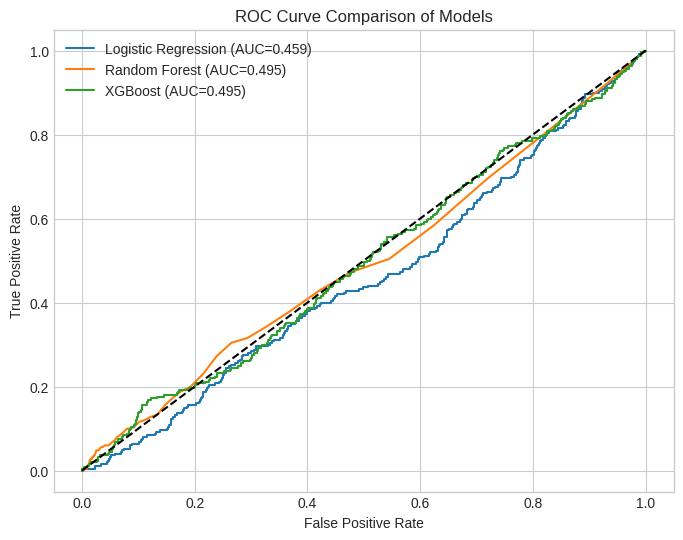

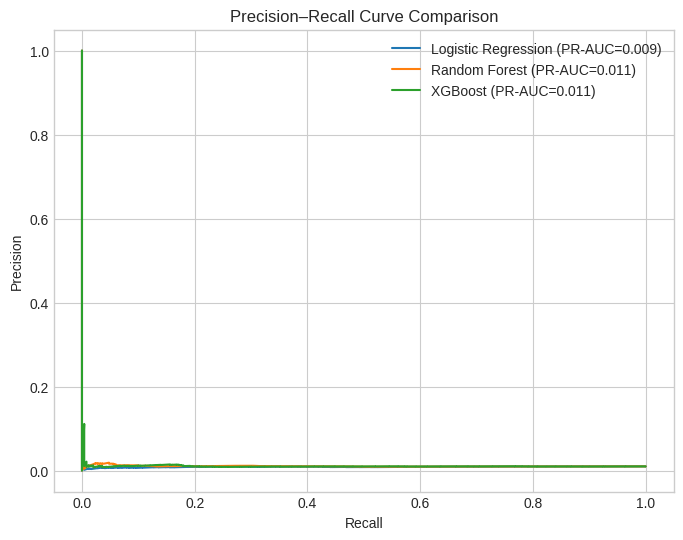

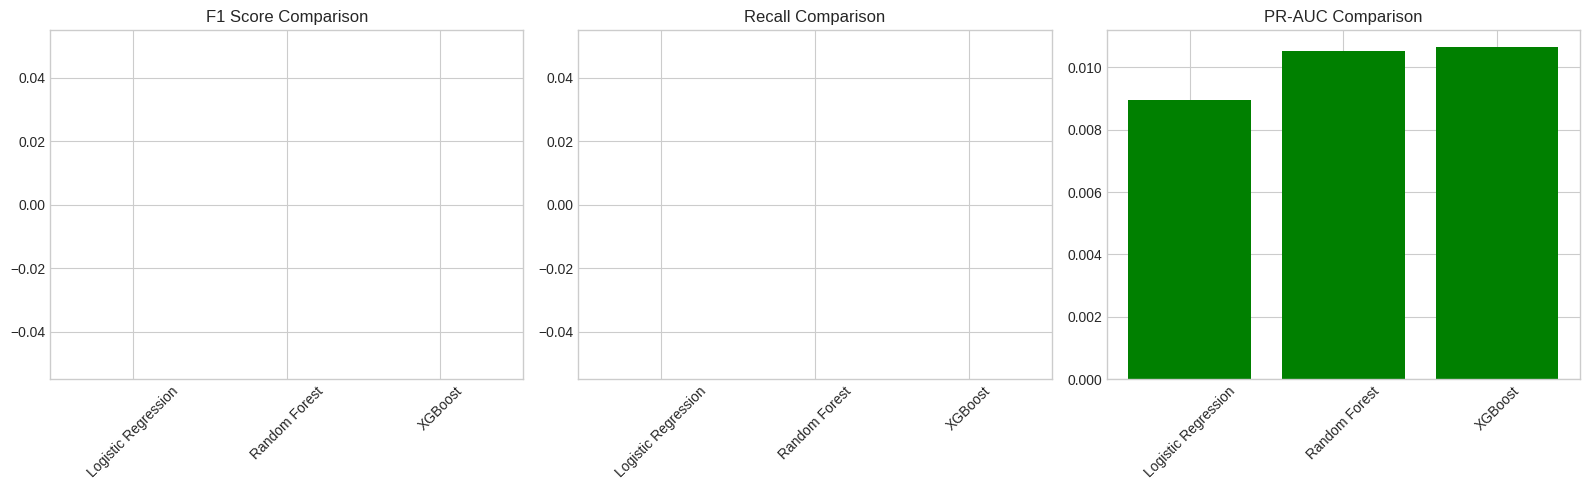

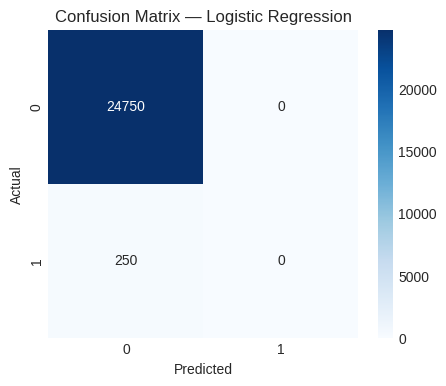

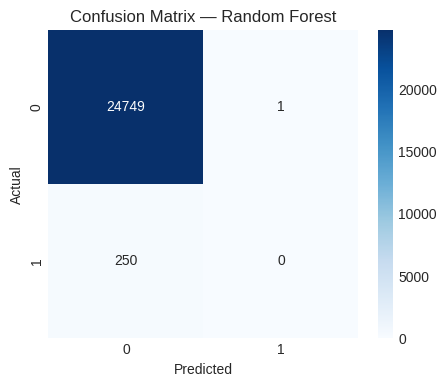

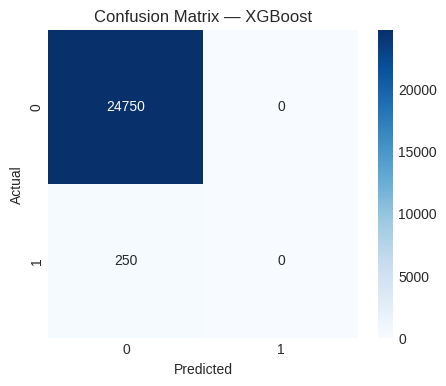

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, recall_score

plt.style.use("seaborn-v0_8-whitegrid")

# Prepare container for performance metrics
roc_auc_scores = {}
pr_auc_scores = {}
f1_scores = {}
recall_scores = {}

# Loop through all trained models
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    # Save metrics
    roc_auc_scores[name] = roc_auc_score(y_test, y_proba)
    pr_auc_scores[name] = average_precision_score(y_test, y_proba)
    f1_scores[name] = f1_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)

# ---------------------------------------------------
# 1. ROC CURVES
# ---------------------------------------------------
plt.figure(figsize=(8,6))
for name, model in fitted_models.items():
    y_proba = model.predict_proba(X_test_processed)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_scores[name]:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.show()

# ---------------------------------------------------
# 2. PRECISION–RECALL CURVES
# ---------------------------------------------------
plt.figure(figsize=(8,6))
for name, model in fitted_models.items():
    y_proba = model.predict_proba(X_test_processed)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc_scores[name]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.show()

# ---------------------------------------------------
# 3. BAR CHART — F1, Recall, PR-AUC
# ---------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(16,5))

# F1 Scores
ax[0].bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
ax[0].set_title("F1 Score Comparison")
ax[0].tick_params(axis='x', rotation=45)

# Recall Scores
ax[1].bar(recall_scores.keys(), recall_scores.values(), color='orange')
ax[1].set_title("Recall Comparison")
ax[1].tick_params(axis='x', rotation=45)

# PR-AUC Scores
ax[2].bar(pr_auc_scores.keys(), pr_auc_scores.values(), color='green')
ax[2].set_title("PR-AUC Comparison")
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 4. CONFUSION MATRIX HEATMAPS FOR EACH MODEL
# ---------------------------------------------------
for name, model in fitted_models.items():
    cm = confusion_matrix(y_test, model.predict(X_test_processed))

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

SELECT BEST MODEL

In [36]:
best_model_name = None
best_score = 0
for name, model in fitted_models.items():
    proba = model.predict_proba(X_test_processed)[:,1]
    score = average_precision_score(y_test, proba)
    if score > best_score:
        best_score = score
        best_model_name = name

best_model = fitted_models[best_model_name]
print("Best Model Selected:", best_model_name)
print("Best PR-AUC:", best_score)

Best Model Selected: XGBoost
Best PR-AUC: 0.010647714225071905


SHAP EXPLAINABILITY

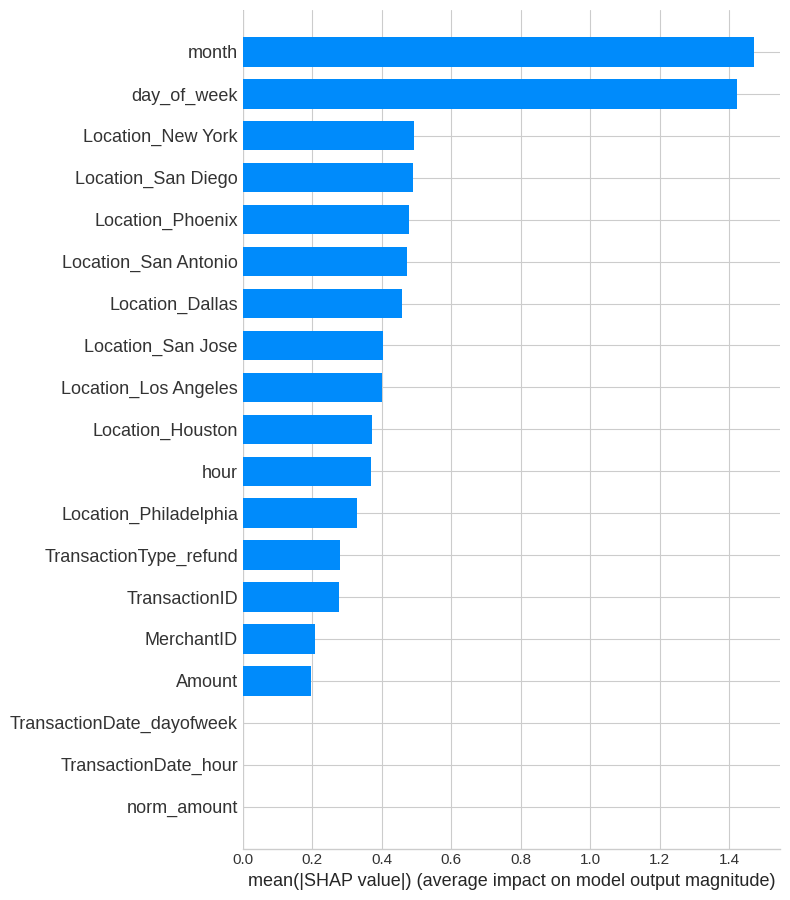

In [38]:
import shap

explainer = shap.TreeExplainer(best_model)
sample = X_test_processed.sample(300, random_state=42)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample, plot_type="bar")

SAVE MODEL & FEATURE ORDER

In [47]:
import joblib
import pandas as pd
import os

os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/best_model.pkl")
# Save the columns of X_train_processed, which is what the model was trained on
pd.Series(X_train_processed.columns).to_csv("models/feature_order.csv", index=False)

print("Model & feature order saved.")

Model & feature order saved.


GENERATE STREAMLIT APP

In [50]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

st.title("Credit Card Fraud Detection System")

pipe = joblib.load("models/best_model.pkl")
# Load feature_order correctly (assuming it's a single column without header from previous save)
feature_order = pd.read_csv("models/feature_order.csv", header=None).squeeze().tolist()

uploaded = st.file_uploader("Upload CSV for prediction", type=['csv'])

if uploaded:
    data = pd.read_csv(uploaded)

    # 1. Replicate Feature Engineering steps
    if 'TransactionDate' in data.columns:
        data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
        data['hour'] = data['TransactionDate'].dt.hour
        data['day_of_week'] = data['TransactionDate'].dt.dayofweek
        data['month'] = data['TransactionDate'].dt.month

    # Feature scaling for Amount (fit new scaler for simplicity, ideally load saved scaler)
    if 'Amount' in data.columns:
        scaler = StandardScaler()
        data['norm_amount'] = scaler.fit_transform(data[['Amount']])
    else:
        # If 'Amount' is missing, norm_amount will also be missing, which would cause an error later.
        # This assumes 'Amount' is always present in raw data.
        pass # Handle this case if 'Amount' can be missing

    # One-hot encode categorical features
    if 'TransactionType' in data.columns:
        data = pd.get_dummies(data, columns=['TransactionType'], drop_first=True)
    if 'Location' in data.columns:
        data = pd.get_dummies(data, columns=['Location'], drop_first=True)

    # Drop the original TransactionDate column if it was used for feature extraction and is not in feature_order
    if 'TransactionDate' in data.columns and 'TransactionDate' not in feature_order:
        data = data.drop(columns=['TransactionDate'])

    # Ensure all columns in feature_order are present, fill missing with 0, and reorder
    # This handles cases where some one-hot encoded columns might be missing in uploaded data
    # (e.g., if uploaded data has no 'TransactionType_refund' or a specific location)
    missing_cols = set(feature_order) - set(data.columns)
    for c in missing_cols:
        data[c] = 0

    # Also, drop columns in data that are not in feature_order (e.g., IsFraud if uploaded for prediction)
    extra_cols = set(data.columns) - set(feature_order)
    if extra_cols:
        data = data.drop(columns=list(extra_cols))

    # Reorder columns to match the order the model was trained on
    data = data[feature_order]

    y_proba = pipe.predict_proba(data)[:,1]
    y_pred = pipe.predict(data)

    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            st.error(f"Row {i}: Fraud Detected (Prob={y_proba[i]:.4f})")
        else:
            st.success(f"Row {i}: No Fraud Detected (Prob_NoFraud={(1 - y_proba[i]):.4f})")


Overwriting app.py


RUN STREAMLIT APP USING NGROK

In [51]:
!pip install pyngrok streamlit
import time
from pyngrok import ngrok

# Kill any existing ngrok processes
ngrok.kill()

# Try to kill any existing Streamlit processes on port 8501
!fuser -k 8501/tcp || true

# IMPORTANT: Replace "YOUR_AUTHTOKEN" with your actual ngrok authtoken
# You can get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("35u1uYywJnpL3u96GEuwizGOErO_5PPi1nYhdZVsRx6bCPdGx")

# Start Streamlit in the background, redirecting output to a log file
!streamlit run app.py > streamlit_log.txt 2>&1 &

# Give Streamlit a moment to start
time.sleep(5)

# Connect ngrok tunnel
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

# Print Streamlit logs to debug potential startup issues
print("\n--- Streamlit App Logs ---")
!cat streamlit_log.txt

8501/tcp:            16573
Public URL: NgrokTunnel: "https://bianca-bedfast-barrett.ngrok-free.dev" -> "http://localhost:8501"

--- Streamlit App Logs ---



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.223.99.99:8501

